In [1]:
from itertools import count

import matplotlib.pyplot as plt
import numba

from chandra_aca.aca_image import ACAImage, AcaPsfLibrary
from chandra_aca.transform import mag_to_count_rate, pixels_to_yagzag
from chandra_aca.attitude import *
from proseco.guide import get_guide_catalog
from proseco.core import ACABox

%matplotlib inline

In [2]:
APL = AcaPsfLibrary()

In [3]:
ROWB = np.array([0, 0, 0, 0, 7, 7, 7, 7])
COLB = np.array([0, 1, 6, 7, 0, 1, 6, 7])
RCB = ROWB * 8 + COLB
MIN_FLOAT_64 = np.finfo(np.float64).min

@numba.jit(nopython=True)
def nanargmax(arr):
    max_val = MIN_FLOAT_64
    argmax = -1
    for ii in range(len(arr)):
        val = arr[ii]
        if not np.isnan(val) and val > max_val:
            max_val = val
            argmax = ii
    return argmax

@numba.jit(nopython=True)
def calc_flight_background(image):
    """
    Calculate average background of the input 8x8 ``image`` using
    the flight PEA background algorithm.
    :param image: 8x8 image (ndarray)
    :returns: bgd_avg
    """
    vals = image.flatten()[RCB]
    while True:
        avg = np.round(np.nanmean(vals))
        sigma = np.maximum(avg * 1.5, 10.0)
        dev = np.abs(vals - avg)
        imax = nanargmax(dev)
        if dev[imax] > sigma:
            vals[imax] = np.nan
        else:
            break

    return avg

In [4]:
def lofi(guides, n_read=300, dt=4.1, dark=None):
    if dark is None:
        dark = guides.dark
    dark = dark.astype(np.float64)

    times = np.arange(n_read) * dt
    omega_r = 2 * np.pi / 1000
    omega_c = 2 * np.pi / 707
    dither_rs = guides.dither.row * np.sin(omega_r * times)
    dither_cs = guides.dither.col * np.sin(omega_c * times)

    sdrs = []
    for guide in guides:
        sdr = star_track(guide, dither_rs, dither_cs, dark=dark, stars=guides.stars)
        sdrs.append(sdr)
        
    return sdrs

In [5]:
def star_track(guide, dither_rs, dither_cs, dark, stars):
    # Find all stars with centroid within a 9-pixel halfw box of guide
    # Note pix_zero_loc = 'edge' for all these
    guide_row0 = guide['row']
    guide_col0 = guide['col']
    ok = ((np.abs(stars['row'] - guide_row0) < 9) &
          (np.abs(stars['col'] - guide_col0) < 9))
    star_row0s = stars['row'][ok]
    star_col0s = stars['col'][ok]
    star_norms = mag_to_count_rate(stars['mag'][ok])

    img_row = guide_row0
    img_col = guide_col0
    
    # print(f'star_row0s={star_row0s}')
    # print(f'img_row={img_row}')

    # Initial rate
    rate_row = 0.0
    rate_col = 0.0
    
    cent_rows = np.zeros_like(dither_rs)
    cent_cols = np.zeros_like(dither_rs)
    norms = np.zeros_like(dither_rs)
    img_row0s = np.zeros_like(dither_rs)
    img_col0s = np.zeros_like(dither_rs)
    
    for idx, dither_r, dither_c in zip(count(), dither_rs, dither_cs):
        # Next image location center as floats
        img_row = (img_row + rate_row).clip(-512 + 4, 512 - 4)
        img_col = (img_col + rate_col).clip(-512 + 4, 512 - 4)

        # Image readout lower left corner
        img_row0 = int(round(img_row)) - 4
        img_col0 = int(round(img_col)) - 4
        img_row0s[idx] = img_row0
        img_col0s[idx] = img_col0
                
        # Definitely optimize this later, making new ACAImage is expensive
        img = dark.aca[img_row0:img_row0 + 8, img_col0:img_col0 + 8].copy()

        # Shine star images onto img
        for star_row0, star_col0, star_norm in zip(star_row0s, star_col0s, star_norms):
            star_row = star_row0 + dither_r
            star_col = star_col0 + dither_c
            img_star = APL.get_psf_image(star_row, star_col, star_norm, pix_zero_loc='edge')
            img += img_star.aca

        bgd = calc_flight_background(np.asarray(img))
        cent_rows[idx], cent_cols[idx], norms[idx] = img.aca.centroid_fm(
            bgd=bgd, pix_zero_loc='edge', norm_clip=10)
        # print(f'cent_row={cent_rows[idx]:.3f}')
        
        rate_row = cent_rows[idx] - img_row
        rate_col = cent_cols[idx] - img_col
        
    out = dict(cent_row=cent_rows, cent_col=cent_cols, norm=norms,
              img_row0=img_row0s, img_col0=img_col0s)
        
    return out

In [6]:
guides = get_guide_catalog(21068, dither=(20, 20))

In [7]:
guides

id,ra,dec,yang,zang,row,col,mag,mag_err,POS_ERR,PM_RA,PM_DEC,MAG_ACA,MAG_ACA_ERR,CLASS,COLOR1,COLOR1_ERR,VAR,ASPQ1,ASPQ2,ASPQ3,RA_PMCORR,DEC_PMCORR,offchip,imp_mag,imp_r,imp_c,stage,stat_1,stat_2,stat_3,stat_4,stat_5,idx
int32,float64,float64,float64,float64,float64,float64,float32,float64,int16,int16,int16,float32,int16,int16,float32,int16,int16,int16,int16,int16,float64,float64,bool,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64
261489768,195.906179,27.591882,-2071.50,-2184.41,423.63,-437.01,9.62,0.13,28,-12,8,9.62268,7,0,0.9656,5,-9999,0,0,999,195.906179,27.591882,False,11.9495575403,428,-446,4,4,4,4,0,0,0
261492456,195.725550,26.391136,-1504.18,2140.05,310.06,435.71,9.67,0.21,33,-8,16,9.67032,18,0,1.1407,6,-9999,0,0,575,195.725550,26.391136,False,12.0190232857,313,437,4,5,4,4,0,0,1
261490800,195.029470,27.224579,730.39,-861.89,-140.70,-167.62,10.13,0.16,38,-30,14,10.1298,7,0,0.91035,7,-9999,0,0,999,195.029470,27.224579,False,11.7790773748,-149,-163,5,5,5,4,4,0,2
261490688,194.649982,27.195247,1945.88,-762.32,-385.65,-147.76,10.26,0.17,30,-9999,-9999,10.2557,6,0,0.4369,5,-9999,0,0,999,194.649982,27.195247,False,11.7499386426,-390,-148,5,5,5,5,4,0,3


In [8]:
time sdrs = lofi(guides, dt=2.05, n_read=1000)

CPU times: user 1.99 s, sys: 50.1 ms, total: 2.04 s
Wall time: 2.12 s


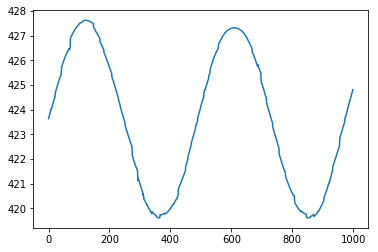

In [9]:
plt.plot(sdrs[0]['cent_row'])

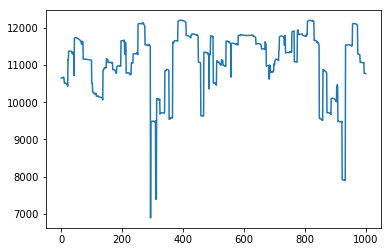

In [10]:
plt.plot(sdrs[0]['norm'])

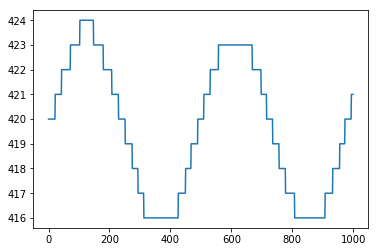

In [11]:
plt.plot(sdrs[0]['img_row0'])

In [12]:
yag = guides['yang']
zag = guides['zang']
yag_obs = np.zeros(shape=(len(sdrs[0]['cent_row']), len(guides)))
zag_obs = np.zeros_like(yag_obs)
for idx, sdr in enumerate(sdrs):
    yags, zags = pixels_to_yagzag(sdr['cent_row'], sdr['cent_col'], pix_zero_loc='edge')
    yag_obs[:, idx] = yags
    zag_obs[:, idx] = zags

In [13]:
time roll, pitch, yaw = calc_roll_pitch_yaw(yag, zag, yag_obs, zag_obs)

CPU times: user 172 ms, sys: 2.63 ms, total: 174 ms
Wall time: 172 ms


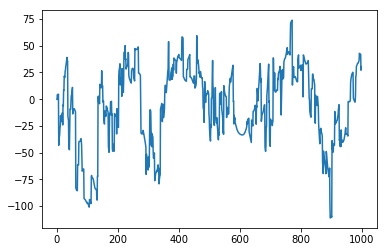

In [14]:
plt.plot(roll * 3600)

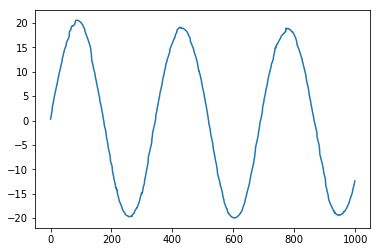

In [15]:
plt.plot(pitch * 3600)